# use class to encapsulate scraping functions

2021/01/03

# 1. Scraping

In [ ]:
%run -i 'STEP1_scraping_cleaning_merge.py'
from datetime import datetime

initial_panels = ['201812', '201907', '201908', '201912', '202001', '202002']
today = datetime.today()
current_panel = today.strftime("%Y%m")
print(current_panel)

for i in initial_panels:
    d1 = scrape(initial_panel=i,
                current_panel=current_panel
                ).create_dir(
                ).open_initial_panel_data(
                ).get_appids_from_initial_panel_data(
                ).scraping_apps_according_to_id()

scraping...:   0%|          | 0/13144 [00:00<?, ?it/s]

202108
201812  first panel contains  5977  IDs.
202108  tracking  201812  has already been scraped.
201907  first panel contains  13144  IDs.
start scraping apps with initial panel 201907


scraping...:   0%|          | 0/13015 [00:00<?, ?it/s]

Saved scarped app details with initial panel 201907
201908  first panel contains  13015  IDs.
start scraping apps with initial panel 201908


scraping...:  59%|█████▉    | 7737/13015 [4:35:27<38:03,  2.31it/s]       

In [9]:
tracking_path = '/home/naixin/Insync/naixin88@sina.cn/OneDrive/_____GWU_ECON_PHD_____/___Dissertation___/____WEB_SCRAPER____/TRACKING_THE_SAME_ID_MONTHLY_SCRAPE'

ispath = os.path.join(tracking_path, current_panel)
print(ispath)
if os.path.isfile(ispath) is False:
    os.makedirs(ispath)
    print("Directory '%s' created" %current_panel)
else:
    print("Directory '%s' has already been created" %current_panel)

/home/naixin/Insync/naixin88@sina.cn/OneDrive/_____GWU_ECON_PHD_____/___Dissertation___/____WEB_SCRAPER____/TRACKING_THE_SAME_ID_MONTHLY_SCRAPE/202108
Directory '202108' created


# Panels Track

In [1]:
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103', '202104',
          '202105', '202106', '202107'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103',
          '202104', '202105', '202106', '202107'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103', '202104', '202105',
          '202106', '202107'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103', '202104', '202105', '202106',
          '202107'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103', '202104', '202105', '202106', '202107'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103', '202104', '202105', '202106', '202107']}

initial_panel = '201907'
all_panels = [
  '201907', '201908', '201909', '201912', '202001', '202003', '202004',
  '202009', '202010', '202011', '202012', '202101', '202102', '202103',
  '202104', '202105', '202106', '202107']

# 2. Convert
You can run this block without running the first scraping block.

In [25]:
%run -i 'STEP1_scraping_cleaning_merge.py'

for initial_panel, all_panels in panels_track.items():
    d1 = convert(
        initial_panel=initial_panel,
        all_panels=all_panels
                 ).open_app_detail_dict(
                 ).merge_panels_into_single_df(
        balanced_panel = False
    )

start merging the dataframe for panel starting  201812
merged dataframe for all the panels above
panel data  201812  has shape :  (5977, 442)
Index(['title_201812', 'description_201812', 'summary_201812',
       'minInstalls_201812', 'score_201812', 'ratings_201812',
       'reviews_201812', 'histogram_201812', 'price_201812', 'free_201812',
       ...
       'developerAddress_202107', 'genreId_202107', 'contentRating_202107',
       'adSupported_202107', 'containsAds_202107', 'released_202107',
       'updated_202107', 'comments_202107', 'appId_202107', 'merge_202107'],
      dtype='object', length=442)
start merging the dataframe for panel starting  201907
merged dataframe for all the panels above
panel data  201907  has shape :  (13285, 496)
Index(['title_201907', 'description_201907', 'summary_201907',
       'minInstalls_201907', 'score_201907', 'ratings_201907',
       'reviews_201907', 'histogram_201907', 'price_201907', 'free_201907',
       ...
       'developerAddress_202107'

# 3. Impute Missing and NLP
Since I will need interval data, so I will only impute from consecutive_panels

I have streamlined code and adjusted containsAds, offersIAP for ALL panels and impute
missing only if all their non-missing panels are the same value.
SAVED in 2021_04_08 / breakthrough_imputed_missing folder.

I will not impute or delete for size variable, since it contains such a large percentage of missing.

In the final regression, I will use a dummy to indicate whether size is missing.
(or simply does not include size).

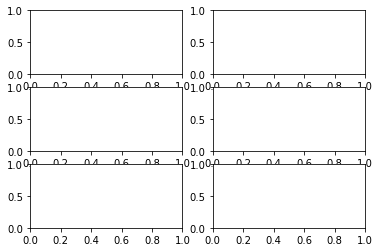

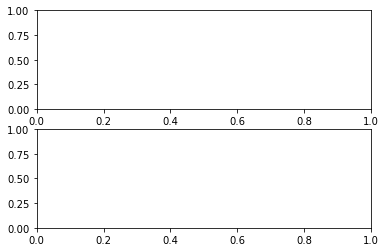

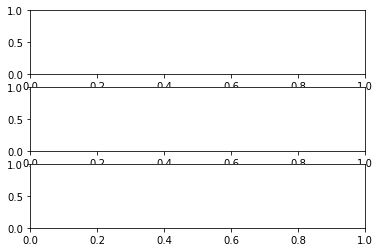

In [17]:
# %run -i 'STEP2_pre_processing.py'
%run -i "STEP3_stats_and_regs.py"

original_vars = ['minInstalls',
                        'score',
                        'reviews',
                        'ratings',
                        'price',
                        'released',
                        'updated',
                        'free',
                        'containsAds',
                        'offersIAP',
                        'contentRating',
                        'genreId'] # add merge_month for unbalanced panel

# dropped ratings variable, too much missing
# two things to note, containgAds and offerIAD are mostly missing in the first few months.
# for more than one imputation method, the list is like a pipe, you first go with previous, then use zero for missing in the first month
# The reasons for using more than one imputation method is because the missing is too many if I just use previous
imputation_var_methods_dict = {
    'time_variant':{
        'contentRating': ['mode'],
        'size': ['mode'],
        'released': ['mode'],
        'score': ['mean'],
        'reviews': ['mean'],
        'developer': ['previous'],
        'price': ['previous'],
        'minInstalls': ['previous'],
        'containsAds': ['mode if all months are the same', 'zero for missing in the first month', 'previous'],
        'adSupported': ['mode if all months are the same', 'zero for missing in the first month', 'previous'],
        'offersIAP': ['mode if all months are the same', 'zero for missing in the first month', 'previous'],},
    'time_invariant':{
        'description': ['any_other'], # the imputed description are used to generate both continuous niche and niche
        'genreId': ['mode']}
}

balanced_newly_created_vars = [
    'developerClean',
    'description_ModeClean',
    'non_top_firm',
    'ML',
    'MF'
]

unbalanced_newly_created_vars = [
    'developerClean',
    'description_ModeClean',
    'top_firm',
    'non_top_firm',
    'ML',
    'MF',
    'T_TO_TIER1_minInstalls',
    'noisy_death',
    'T_TO_top_firm',
    'MA'
]

In [8]:
# for essay 3 unbalanced panel, balanced = False
# ***************************************************************************************
%run -i "STEP2_pre_processing.py"
for b in [False, True]:
    if b is False:
        for initial_panel, all_panels in panels_track.items():
            if initial_panel == '201907':
                d1 = pre_processing(
                            initial_panel=initial_panel,
                            all_panels=all_panels,
                            tcn = 'description'
                    # ).impute_missing(
                    #         imputation_var_methods_dict=imputation_var_methods_dict,
                    #         balanced=b
                    ).create_adultcontent_var(
                            balanced=b
                    ).create_daysreleased_var(
                            balanced=b
                    ).convert_true_false_to_1_0_dummies(
                                balanced=b,
                                vl = ['containsAds', 'offersIAP']
                    ).clean_and_prepare_app_description(
                            balanced=b
                    ).create_top_firm_dummy(
                            balanced=b
                    ).unbalanced_panel_create_TRANSITION_top_firm_and_MA_dummy(
                    ).unbalanced_panel_create_TRANSITION_tier1_minInstalls(
                    ).unbalanced_panel_create_noisy_death_dummy(
                    ).create_sub_sample_dummies(
                            balanced=b
                    # ).slice_text_cols_for_sub_samples(
                    #         balanced=b
                    # ).tf_idf_transformation(
                    # ).find_optimal_svd_component_dict(
                    #         cutoff_percent_explained=0.85
                    # ).truncate_svd(
                    #         random_state=0
                    # ).optimal_k_elbow(
                    #         type='distortion'
                    # ).optimal_k_elbow(
                    #         type='inertia'
                    # ).optimal_k_silhouette(
                    # ).determine_optimal_k_from_silhouette(
                    # ).kmeans_cluster(
                    #         random_state=0
                    # ).create_continuous_and_dummy_niche_variable(
                )

-------------------- create_adultcontent_var -------------------------
Open imputed dataframe
------------------------ open_df imputed ---------------------------
Index(['title_201907', 'description_201907', 'summary_201907',
       'minInstalls_201907', 'score_201907', 'ratings_201907',
       'reviews_201907', 'histogram_201907', 'price_201907', 'free_201907',
       ...
       'imputed_offersIAP_202101', 'imputed_offersIAP_202102',
       'imputed_offersIAP_202103', 'imputed_offersIAP_202104',
       'imputed_offersIAP_202105', 'imputed_offersIAP_202106',
       'imputed_offersIAP_202107', 'imputed_description', 'mode_genreId',
       'imputed_genreId'],
      dtype='object', length=706)
Everyone                                                                                                        9340
Teen                                                                                                            1752
['Everyone']                                                      

# 4. Descriptive Statistics and Regression

------------------------ create_subsample_dict_and_merge_in_niche_vars ---------------------------
------------------------ open_df imputed ---------------------------
------------------------ _create_categorical_sub_sample_vars ----------------------
FULL         category
ML_MF        category
ML_CAT       category
MF_CAT       category
FULL_TIER    category
FULL_FIRM    category
FULL_CAT     category
dtype: object
(13285, 1013)
FULL--- before merging in niche variables
(13285, 1013)
FULL--- after merging in niche variables
(13285, 1053)
FULL--- delete missing in the original unscaled variables
(2359, 259)
------------------------ _scale_var_printout_descriptive_stats ----------------------
reviews_201907 BEFORE nlog_plus_one
count    2.359000e+03
mean     1.076889e+05
std      4.088063e+05
min      0.000000e+00
25%      3.536500e+03
50%      1.669100e+04
75%      6.936900e+04
max      1.083972e+07
Name: reviews_201907, dtype: float64
reviews_201907 AFTER nlog_plus_one
count    2359.0

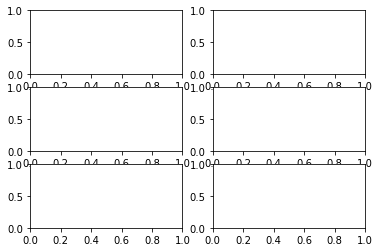

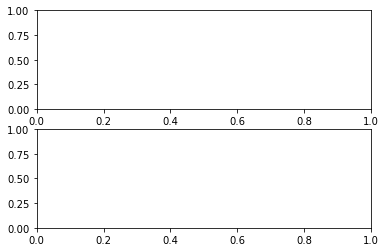

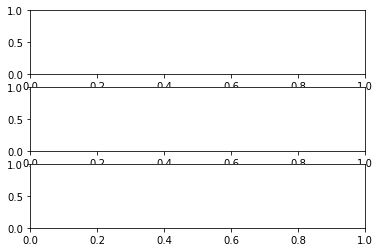

In [29]:


%run -i "STEP3_stats_and_regs.py"
for b in ['balanced', 'unbalanced']:
    if b == 'unbalanced':
        for initial_panel, all_panels in panels_track.items():
            if initial_panel == '201907':
                d1 = stats_and_regs(
                            initial_panel=initial_panel,
                            all_panels=all_panels
                    ).create_subsample_dict_and_merge_in_niche_vars_and_scale_vars(
                            balanced=b
                    ).des_stats_as_in_dissertation_format(
                            balanced=b
                    # ).des_stats_continuous_niche(
                    #         balanced=b
                    # ).table_cat_y_variables_against_niche_dummy(
                    #         balanced=b
                    # ).graph_y_variables_against_niche(
                    #         balanced=b
                    # ).heatmap_among_variables(
                    #         balanced=b
                    # ).price_elasticity_regression(
                    #         balanced=b
                    # ).cross_section_regression(
                    #         balanced=b
                    # ).summarize_ols_results(
                    #         balanced=b,
                    #         stacked=False
                    # ).stacked_cross_section_regression(
                    #         balanced=b
                    # ).summarize_ols_results(
                    #         balanced=b,
                    #         stacked=True
                    # ).summarize_ols_results_in_graph(
                    #         balanced=b
                    # ).panel_regression(
                    #         balanced=b,
                    #         type='pooled_ols'
                )

 ## TEST


(12281, 5)
['non_top_firm' 'top_firm']
[0 1]


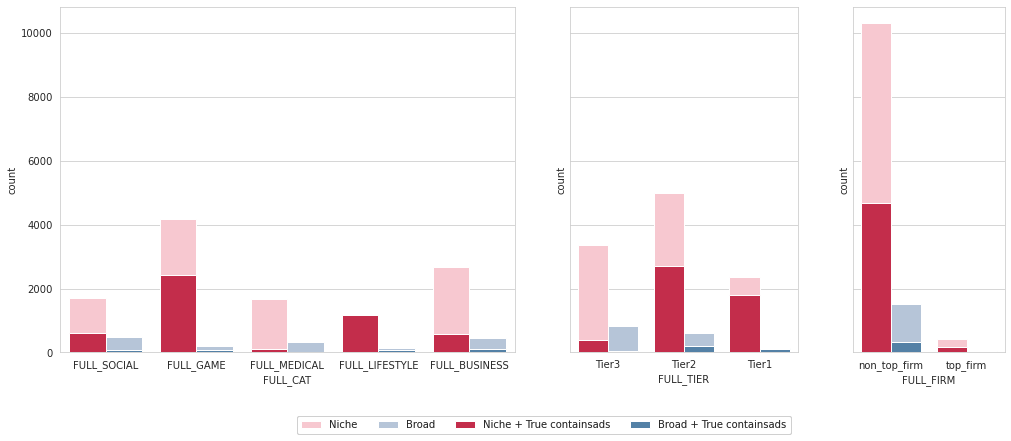

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = d1.imputed_dict['FULL']['FULL'].copy()
df2 = df[['imputed_containsAdsdummy_201907', 'dummy_niche_201907', 'FULL_CAT', 'FULL_TIER', 'FULL_FIRM']]
print(df2.shape)
ss_full = ['FULL_CAT', 'FULL_TIER', 'FULL_FIRM']
fig, axes = plt.subplots(nrows=1,
                         ncols=len(ss_full),
                         figsize=(16,6),
                         gridspec_kw={'width_ratios': [3, 1.5, 1]},
                                      sharey='row', sharex='col')
plt.subplots_adjust(bottom=0.1, left=0.08, top=0.9)
sns.set_style("whitegrid")
ss_full = ['FULL_CAT', 'FULL_TIER', 'FULL_FIRM']
print(pd.unique(df2[ss_full[i]]))
print(pd.unique(df2['imputed_containsAdsdummy_201907']))
for i in range(len(ss_full)):
    # df3 = df2.value_counts(subset=[ss_full[i], 'dummy_niche_201907']).rename('count').reset_index()
    # print(df3)
    # df4 = df2.loc[df2['imputed_containsAdsdummy_201907']==1]
    # df4 = df4.value_counts(subset=[ss_full[i], 'dummy_niche_201907']).rename('true').reset_index()
    # print(df4)
    df5 = df2.loc[df2['imputed_containsAdsdummy_201907']==1]
    # df5 = df5.value_counts(subset=[ss_full[i], 'dummy_niche_201907']).rename('true').reset_index()
    # print(df5)
    # df6 = df2.value_counts(subset=[ss_full[i], 'dummy_niche_201907']).rename('total').reset_index()
    # print(df6)
    sns.countplot(x=ss_full[i], data=df2, hue='dummy_niche_201907', ax=axes[i], hue_order=[1,0], palette={1: 'pink', 0: 'lightsteelblue'})
    axes[i].legend(labels=['Niche', 'Broad'])
    sns.countplot(x=ss_full[i], data=df5, hue='dummy_niche_201907', ax=axes[i], hue_order=[1,0], palette={1: 'crimson', 0: 'steelblue'})
    axes[i].legend(labels=['Niche + True', 'Broad + True'])
    # legend_labels, _= axes[i].get_legend_handles_labels()
    # fig.legend(legend_labels, ['man1','woman1','child1'], loc='upper right', title=legend_title)
    # df6 = pd.merge(df4, df5, on=[ss_full[i], 'dummy_niche_201907'])
    # df6 = df6.set_index(ss_full[i])
    # print(df6)
    # df3.groupby('dummy_niche_201907').plot(kind="bar", stacked=False, color=['pink', 'lightskyblue'],
    #          ax=axes[i])
    # df4.groupby('dummy_niche_201907').plot(kind="bar", stacked=False, color=['red', 'steelblue'],
    #          ax=axes[i])
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, labels=['Niche', 'Broad', 'Niche + True containsads', 'Broad + True containsads'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))
    axes[i].get_legend().remove()
#----------------- save ---------------------------------------
f_name = ss_full[i] + '_' + 'imputed_containsAdsdummy_201907' + '.png'
q = '/home/naixin/Insync/naixin88@sina.cn/OneDrive/_____GWU_ECON_PHD_____/___Dissertation___/___WEB_SCRAPER___/____DESCRIPTIVE_STATS____/GRAPHS/' + 'test/' + f_name
fig.savefig(q, facecolor='w', edgecolor='w', dpi=300)

In [26]:
f_name = '/home/naixin/Insync/naixin88@sina.cn/OneDrive/_____GWU_ECON_PHD_____/___Dissertation___/___WEB_SCRAPER___/____OLS_RESULTS____/summary_results/unbalanced_continuous_niche_imputed_ols_cross_sectional_results.csv'
df = pd.read_csv(f_name)
df.reset_index(inplace=True)
df.rename(columns={
    'Unnamed: 0': 'Month',
    'Unnamed: 1': 'Sub-sample'}, inplace=True)
df2 = df.loc[df['Sub-sample'].isin(['Tier1', 'Tier2']), ['Month', 'Sub-sample', "nlog_imputed_price"]].copy()
df2["nlog_imputed_price"] = df2['nlog_imputed_price'].apply(lambda x: x.replace('*', ''))
df2["nlog_imputed_price"] = pd.to_numeric(df2["nlog_imputed_price"])
df2['Month'] = pd.to_datetime(df2['Month'], format='%Y%m')
df2 = df2.sort_values(by=['Month'])
print(df2.head())
# print(df.columns)

        Month Sub-sample  nlog_imputed_price
1  2019-07-01  Tier1      0.00              
2  2019-07-01  Tier2     -0.06              
24 2019-08-01  Tier1      0.00              
25 2019-08-01  Tier2     -0.06              
47 2019-09-01  Tier1      0.00              


In [21]:
print(sns.color_palette("hls", 5))

[(0.86, 0.3712, 0.33999999999999997), (0.7247999999999999, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.5792000000000002), (0.33999999999999997, 0.5167999999999995, 0.86), (0.7871999999999999, 0.33999999999999997, 0.86)]


In [ ]:
df2 = d1.original_dict['FULL']['FULL'].copy()
df2.reset_index(inplace=True)
df2.rename(columns = {'index': 'app_id'}, inplace=True)
# print(list(df2.columns))
all_panels = ['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103',
          '202104', '202105', '202106', '202107']
core_x = ['score', 'nlog_reviews', 'adultcontent', 'daysreleased', 'size', 'dummy_niche', 'continuous_niche', 'post', 'post_niche']
core_y = ['containsAdsdummy', 'offersIAPdummy', 'noisy_death', 'T_TO_TIER1_minInstalls', 'T_TO_top_firm', 'MA', 'nlog_price', 'nlog_minInstalls']
df3 = df2.loc[:, ['app_id', 'nlog_reviews_201907', 'nlog_reviews_202003', 'price_201907', 'price_202003']]
df3 = pd.wide_to_long(df3, ['nlog_reviews', 'price'], sep='_', i='app_id', j='year')
print(df3.head())


In [9]:
df2 = d1.ss_data_dict['original']['FULL']['FULL'].copy()

In [32]:
from datetime import datetime
df2['daysreleased_201907'].describe()
#     x = str(x)
#     xm = datetime.strptime(m, "%Y%m")
#     stay_at_home_order = datetime.date(2020, 3, 1)
#     if xm > stay_at_home_order:
#         return 1
#     else:
#         return 0
# for m in ['201907', '202004']:
#     df2['post_' + m] = df2['post_' + m].apply(lambda x: _create_post_dummy(x))
# print(df2[['post_201907']].head())
# print(df2[['post_201907']].dtypes)

count    2359.000000
mean     1011.654091
std      840.066345 
min      0.000000   
25%      318.000000 
50%      789.000000 
75%      1514.000000
max      3408.000000
Name: daysreleased_201907, dtype: float64

In [11]:
print(df2.head())

                                                     price_201907  \
air.MSPMobile                                        0.0            
air.bg.lan.Monopoli                                  0.0            
air.com.bigfishgames.fairwayrevengegooguniversalf2p  0.0            
air.com.come2play.backgammon                         0.0            
air.com.freshplanet.games.WaM                        0.0            

                                                     minInstalls_201907  \
air.MSPMobile                                        10000000.0           
air.bg.lan.Monopoli                                  10000000.0           
air.com.bigfishgames.fairwayrevengegooguniversalf2p  5000000.0            
air.com.come2play.backgammon                         1000000.0            
air.com.freshplanet.games.WaM                        10000000.0           

                                                     containsAdsdummy_201907  \
air.MSPMobile                                        1

In [3]:
cols = ['after_1', 'after_2', 'A', 'B']
new_cols = [i for i in cols if 'after_' in i ]
months = ['201907', '201908']
new_cols = ['continuous_niche_' + m for m in months]
print(new_cols)

['continuous_niche_201907', 'continuous_niche_201908']
